In [2]:
!pip install surprise

import sys
import random
from surprise import Dataset, Reader
from surprise import KNNBasic
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.dataset import DatasetAutoFolds
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import operator
import requests
from zipfile import ZipFile

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2505172 sha256=5c269b13b23cc8c358e5d10d0fd175cc97fe21fbb52f2c995bedcc7cb9fbb562
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


In [3]:
import random

df = pd.read_csv('/content/drive/MyDrive/colleb/ujsp/ratings.csv',
                 skiprows=lambda i: i > 0 and random.random() > 0.002,
                 on_bad_lines="skip")

print(len(df))

50130


In [4]:
df=df[0:20000]

In [5]:
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(df[['userId','movieId','rating']], reader)
print(type(data))

<class 'surprise.dataset.DatasetAutoFolds'>


In [6]:
# Split the data into training and testing sets
trainset, testset = train_test_split(data, test_size=0.25)
print(type(trainset))

<class 'surprise.trainset.Trainset'>


In [7]:
import itertools

for uid, iid, rating in itertools.islice(trainset.all_ratings(), 5):
    print(f"User {uid} rated item {iid} with a rating of {rating}")

print()
for uid, iid, rating in testset[:5]:
    print(f"User {uid} rated item {iid} with a rating of {rating}")

print()
print(trainset.n_ratings,len(testset))

User 0 rated item 0 with a rating of 4.0
User 1 rated item 1 with a rating of 3.0
User 2 rated item 2 with a rating of 4.0
User 3 rated item 3 with a rating of 4.0
User 3 rated item 1898 with a rating of 5.0

User 61911 rated item 68194 with a rating of 4.0
User 61913 rated item 193065 with a rating of 3.5
User 39742 rated item 25748 with a rating of 4.5
User 22616 rated item 8961 with a rating of 3.5
User 1785 rated item 19 with a rating of 2.0

15000 5000


In [8]:
# Use the KNNBasic algorithm to train the model
algo = KNNBasic()
algo.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [9]:
# Test the model on the testing set
predictions = algo.test(testset)

In [10]:
for uid, iid, rating in testset[:5]:
    print(f"User {uid} rated item {iid} with a rating of {rating}")

User 61911 rated item 68194 with a rating of 4.0
User 61913 rated item 193065 with a rating of 3.5
User 39742 rated item 25748 with a rating of 4.5
User 22616 rated item 8961 with a rating of 3.5
User 1785 rated item 19 with a rating of 2.0


In [11]:
for prediction in predictions[0:5]:
    print(prediction)

user: 61911      item: 68194      r_ui = 4.00   est = 3.51   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}
user: 61913      item: 193065     r_ui = 3.50   est = 3.51   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}
user: 39742      item: 25748      r_ui = 4.50   est = 3.51   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}
user: 22616      item: 8961       r_ui = 3.50   est = 3.51   {'was_impossible': True, 'reason': 'Not enough neighbors.'}
user: 1785       item: 19         r_ui = 2.00   est = 3.51   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


In [12]:
# Print the performance metrics
accuracy.rmse(predictions)

RMSE: 1.0526


1.0526338845644925

In [13]:
true_ratings = [pred.r_ui for pred in predictions]
est_ratings = [pred.est for pred in predictions]
uids = [pred.uid for pred in predictions]

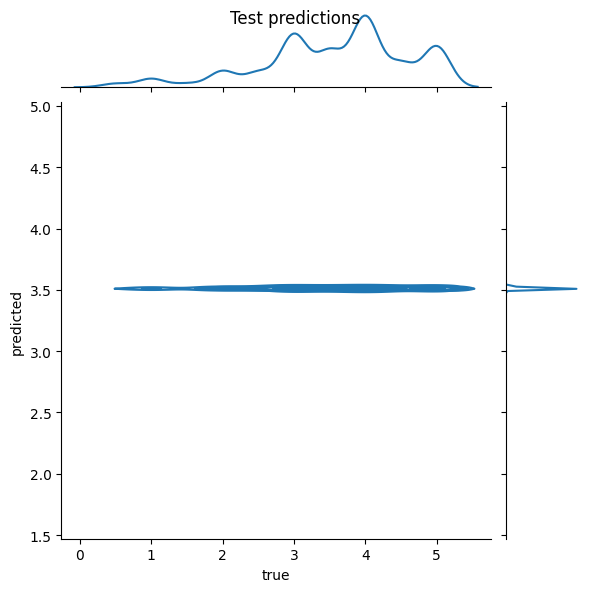

In [14]:
data=pd.DataFrame(columns=["true","predicted"])
data["true"]=true_ratings
data["predicted"]=est_ratings
g = sns.jointplot(data=data,x="true", y="predicted", kind="kde",)
g.fig.suptitle('Test predictions',fontsize=12)
plt.show()

In [15]:
movies=pd.read_csv('/content/drive/MyDrive/colleb/ujsp/movies.csv')
mapping = movies.set_index("movieId")["title"].to_dict()

In [16]:
users=list(set(uids))

In [17]:
# items which the user not yet evaluate
items = trainset.build_anti_testset()
for user in users[0:30]:
    user_items = list(filter(lambda x: x[0] == user, items))
    #print(user,len(user_items))
    # generate recommendation
    recommendations = algo.test(user_items)
    if len(recommendations)>0:
        recommendations.sort(key=operator.itemgetter(3), reverse=True)
        print(f"For User {user}, Recommendations:")
        for r in recommendations[0:5]:
            print(f"  {mapping[r[1]]} : Estimated rating {round(r[3],4)}")

For User 24581, Recommendations:
  Room with a View, A (1986) : Estimated rating 5
  Searching for Sugar Man (2012) : Estimated rating 4.5
  Mysterious Island (1961) : Estimated rating 4.0
  Conspirator, The (2010) : Estimated rating 4.0
  America, America (1963) : Estimated rating 4.0
For User 32778, Recommendations:
  Opposite of Sex, The (1998) : Estimated rating 4.0
  All Dogs Go to Heaven (1989) : Estimated rating 4.0
  Bounce (2000) : Estimated rating 4.0
  Tomorrow Never Dies (1997) : Estimated rating 3.5112
  Lethal Weapon 2 (1989) : Estimated rating 3.5112
For User 49177, Recommendations:
  Avatar (2009) : Estimated rating 5
  Avengers: Infinity War - Part I (2018) : Estimated rating 4.0
  Tomorrow Never Dies (1997) : Estimated rating 3.5112
  Lethal Weapon 2 (1989) : Estimated rating 3.5112
  Crimson Tide (1995) : Estimated rating 3.5112
For User 32794, Recommendations:
  American Werewolf in London, An (1981) : Estimated rating 5
  Pulp Fiction (1994) : Estimated rating 4.0
